Evaluate the impact of a silver-coated mirror vs. an aluminum-coated mirror.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import pandas as pd
from rubin_sim.phot_utils import Bandpass
import syseng_throughputs as st

In [2]:
defaultDirs = st.setDefaultDirs()
defaultDirs

{'detector': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/detector/joint_minimum',
 'lens1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens1',
 'lens2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens2',
 'lens3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/lens3',
 'filters': '/Users/lynnej/lsst_repos/syseng_throughputs/components/camera/filters',
 'mirror1': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror1',
 'mirror2': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror2',
 'mirror3': '/Users/lynnej/lsst_repos/syseng_throughputs/components/telescope/mirror3',
 'atmosphere': '/Users/lynnej/lsst_repos/syseng_throughputs/siteProperties'}

In [3]:
# Read the non-mirror components
detector = st.buildDetector(defaultDirs['detector'])
lens1 = st.buildLens(defaultDirs['lens1'])
lens2 = st.buildLens(defaultDirs['lens2'])
lens3 = st.buildLens(defaultDirs['lens3'])
filters = st.buildFilters(defaultDirs['filters'])
atmos = st.readAtmosphere(defaultDirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')

In [4]:
# We need a silver mirror and an aluminum mirror
os.listdir(defaultDirs['mirror1']), os.listdir(defaultDirs['mirror2']), os.listdir(defaultDirs['mirror3'])

(['m1_ProtAl_Ideal.dat', 'm1_Losses'],
 ['m2_Losses', 'm2_ProtAg_Ideal.dat'],
 ['m3_Losses', 'm3_ProtAl_Ideal.dat'])

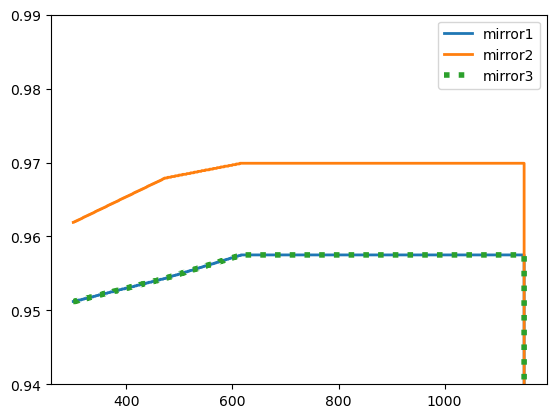

In [5]:
# check if mirror losses are the same ..
losses = {}
for m in ('mirror1', 'mirror2', 'mirror3'):
    losses[m] = Bandpass()
    losses[m].read_throughput(os.path.join(defaultDirs[m], '%s%s_Losses' % (m[0],m[-1]), 
                                          '%s%s_Losses.dat' % (m[0], m[-1])))
    linestyle = '-'
    width=2
    if m == 'mirror3':
        linestyle=':'
        width=4
    plt.plot(losses[m].wavelen, losses[m].sb, linestyle=linestyle, linewidth=width, label=m)
plt.ylim(0.94, 0.99)
plt.legend()

In [6]:
# Mirror losses are not the same (up vs. down-facing I think), so turn them off for now.
mirror = {}
mirror['Al'] = st.buildMirror(defaultDirs['mirror1'], addLosses=False)
mirror['Ag'] = st.buildMirror(defaultDirs['mirror2'], addLosses=False)
# BUT because they are not material dependent and just multiply by the mirror throughput .. 
# we can add them back anyway (as we do below)

In [7]:
# Ok .. 8 combos are actually 4 because it doesn't matter which order the mirrors are in.
combos = [['Al', 'Al', 'Al'], ['Al', 'Ag', 'Al'], ['Ag', 'Al', 'Ag'], ['Ag', 'Ag', 'Ag']]

m5 = {}
m5_badrd = {}
system_all = {}
for combo in combos:
    hardware = {}
    system = {}
    for f in filters:
        wavelen = detector.wavelen
        # Hardware
        sb = detector.sb * lens1.sb * lens2.sb * lens3.sb * filters[f].sb
        sb *= losses['mirror1'].sb * losses['mirror2'].sb * losses['mirror3'].sb
        sb *= mirror[combo[0]].sb * mirror[combo[1]].sb * mirror[combo[2]].sb
        hardware[f] = Bandpass()
        hardware[f].set_bandpass(wavelen, sb)
        system[f] = Bandpass()
        system[f].set_bandpass(wavelen, sb * atmos.sb)
    system_all['-'.join(combo)] = system
    # Default exptime values put u=1x30, grizy = 2x15
    m5['-'.join(combo)] = st.makeM5(hardware, system)
    m5_badrd['-'.join(combo)] = st.makeM5(hardware, system, exptime=30, nexp=1, readnoise=18, 
                                          othernoise=0, darkcurrent=0.2)

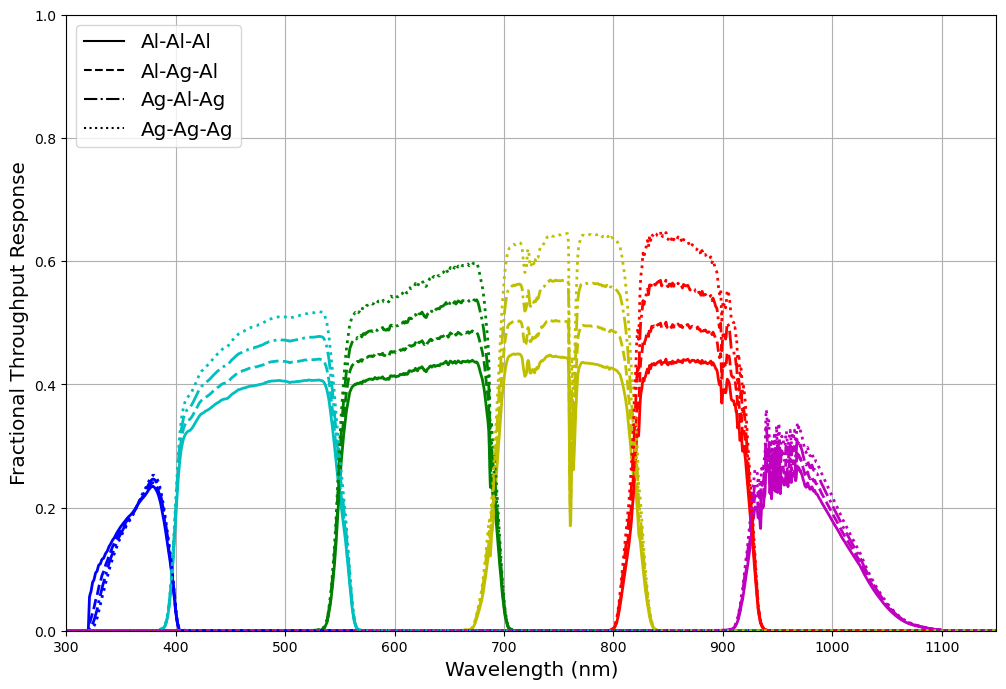

In [8]:
# Plot the entire throughputs
plt.figure(figsize=(12, 8))
linestyles = ['-', '--', '-.', ':']
leg_elements = []
for i, combo in enumerate(combos):
    label = '-'.join(combo)
    linestyle= linestyles[i]
    st.plotBandpasses(system_all['-'.join(combo)], newfig=False, addlegend=False, linestyle=linestyle)
    leg_elements.append(Line2D([0], [0], color='k', linestyle=linestyle, label=label))
plt.legend(handles=leg_elements, loc='upper left', fontsize='x-large', fancybox=True)

Text(0, 0.5, 'Reflectivity')

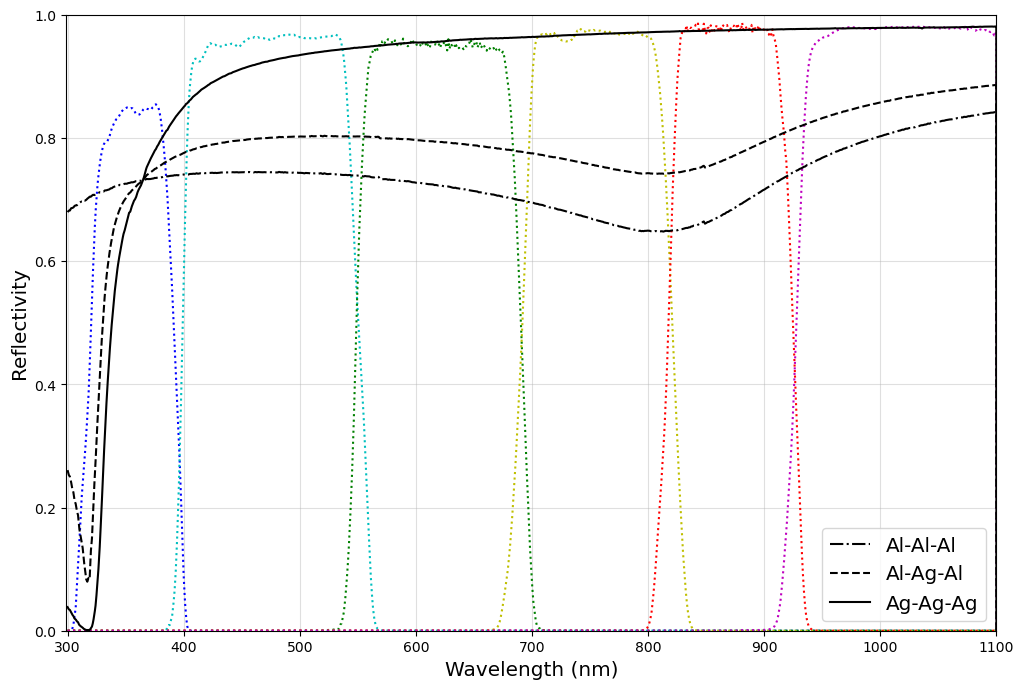

In [9]:
# Plot JUST the mirror reflectivities, for the all Aluminum or all Silver or Al-Ag-Al sets
mirror_plot = [['Al', 'Al', 'Al'], ['Al', 'Ag', 'Al'], ['Ag', 'Ag', 'Ag']]

mirrors = {}
for combo in mirror_plot:
    name = '-'.join(combo)
    wavelen = mirror[combo[0]].wavelen
    sb = mirror[combo[0]].sb * mirror[combo[1]].sb * mirror[combo[2]].sb
    mirrors[name] = Bandpass()
    mirrors[name].set_bandpass(wavelen, sb)

   
# Plot the mirror reflectivities
plt.figure(figsize=(12, 8))
st.plotBandpasses(filters, newfig=False, linestyle=':', linewidth=1.5, addlegend=False)
linestyles = ['-.', '--', '-']
leg_elements = []
for i, combo in enumerate(mirror_plot):
    name = '-'.join(combo)
    linestyle= linestyles[i]
    plt.plot(mirrors[name].wavelen, mirrors[name].sb, color='k', linestyle=linestyle)
    leg_elements.append(Line2D([0], [0], color='k', linestyle=linestyle, label=name))

plt.legend(handles=leg_elements, loc='lower right', fontsize='x-large', fancybox=True)
plt.grid(True, alpha=0.4)
plt.xlim(299, 1100)
plt.ylim(0, 1)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectivity")

In [10]:
d = pd.DataFrame({'Al-Al-Al': m5['Al-Al-Al'].m5, 'Al-Ag-Al': m5['Al-Ag-Al'].m5,
                  'Ag-Al-Ag': m5['Ag-Al-Ag'].m5, 'Ag-Ag-Ag': m5['Ag-Ag-Ag'].m5})
d_badrd = pd.DataFrame({'Al-Al-Al': m5_badrd['Al-Al-Al'].m5, 'Al-Ag-Al': m5_badrd['Al-Ag-Al'].m5,
                  'Ag-Al-Ag': m5_badrd['Ag-Al-Ag'].m5, 'Ag-Ag-Ag': m5_badrd['Ag-Ag-Ag'].m5})
d

,Al-Al-Al,Al-Ag-Al,Ag-Al-Ag,Ag-Ag-Ag
u,24.028433,24.004917,23.992148,23.985045
g,24.804863,24.853418,24.901479,24.949060
r,24.319923,24.379565,24.438578,24.497000
i,23.896197,23.969995,24.042963,24.115178
z,23.335446,23.407204,23.478540,23.549496
y,22.411829,22.455399,22.498850,22.542187


In [11]:
delta_m5 = (d.T - d['Al-Ag-Al'].T)
delta_m5_badrd = d_badrd.T - d['Al-Ag-Al'].T
delta_m5 = delta_m5.T.join(delta_m5_badrd.T, rsuffix='_bdRd')
delta_m5
# Positive values mean deeper limiting magnitudes

,Al-Al-Al,Al-Ag-Al,Ag-Al-Ag,Ag-Ag-Ag,Al-Al-Al_bdRd,Al-Ag-Al_bdRd,Ag-Al-Ag_bdRd,Ag-Ag-Ag_bdRd
u,0.023516,0.0,-0.012768,-0.019871,-0.453087,-0.496659,-0.520744,-0.534757
g,-0.048556,0.0,0.048061,0.095642,-0.190101,-0.135290,-0.081091,-0.027503
r,-0.059642,0.0,0.059013,0.117435,-0.149446,-0.083552,-0.018601,0.045445
i,-0.073799,0.0,0.072967,0.145183,-0.140785,-0.060362,0.018695,0.096486
z,-0.071758,0.0,0.071336,0.142291,-0.118171,-0.041994,0.033397,0.108064
y,-0.043570,0.0,0.043450,0.086787,-0.080777,-0.034841,0.010843,0.056285


In [12]:
# Effective time calculation
# Fractional change in effective time is proportional to change in m5.
# HERE - longer time = better
dtime = np.power(10, 0.8 * (delta_m5))
dtime

,Al-Al-Al,Al-Ag-Al,Ag-Al-Ag,Ag-Ag-Ag,Al-Al-Al_bdRd,Al-Ag-Al_bdRd,Ag-Al-Ag_bdRd,Ag-Ag-Ag_bdRd
u,1.044271,1.0,0.976754,0.964057,0.434041,0.400564,0.383182,0.373417
g,0.914440,1.0,1.092569,1.192651,0.704562,0.779414,0.861245,0.950599
r,0.895955,1.0,1.114834,1.241504,0.759352,0.857350,0.966316,1.087316
i,0.872893,1.0,1.143863,1.306610,0.771564,0.894768,1.035038,1.194507
z,0.876181,1.0,1.140430,1.299670,0.804383,0.925561,1.063452,1.220256
y,0.922877,1.0,1.083329,1.173357,0.861744,0.937837,1.020174,1.109247


In [13]:
SRD_time_distribution = pd.Series({'u': 0.068, 'g': 0.097, 'r': 0.223, 'i': 0.223, 'z': 0.194, 'y': 0.194})
SRD_time_distribution 

u    0.068
g    0.097
r    0.223
i    0.223
z    0.194
y    0.194
dtype: float64

In [14]:
weighted_dtime = dtime.multiply(SRD_time_distribution, axis=0)
weighted_dtime

,Al-Al-Al,Al-Ag-Al,Ag-Al-Ag,Ag-Ag-Ag,Al-Al-Al_bdRd,Al-Ag-Al_bdRd,Ag-Al-Ag_bdRd,Ag-Ag-Ag_bdRd
u,0.071010,0.068,0.066419,0.065556,0.029515,0.027238,0.026056,0.025392
g,0.088701,0.097,0.105979,0.115687,0.068343,0.075603,0.083541,0.092208
r,0.199798,0.223,0.248608,0.276855,0.169335,0.191189,0.215488,0.242471
i,0.194655,0.223,0.255081,0.291374,0.172059,0.199533,0.230813,0.266375
z,0.169979,0.194,0.221243,0.252136,0.156050,0.179559,0.206310,0.236730
y,0.179038,0.194,0.210166,0.227631,0.167178,0.181940,0.197914,0.215194


In [15]:
weighted_dtime.sum()

Al-Al-Al         0.903181
Al-Ag-Al         0.999000
Ag-Al-Ag         1.107497
Ag-Ag-Ag         1.229240
Al-Al-Al_bdRd    0.762480
Al-Ag-Al_bdRd    0.855063
Ag-Al-Ag_bdRd    0.960122
Ag-Ag-Ag_bdRd    1.078371
dtype: float64